 Quelles sont les 20 premières stations en terme de validations ?
- Proposez une illustration graphique de ce classement.

- Proposez une classification des arrêts en vous basant sur le nombre de validations par catégorie de titre ?

- Quelles prédictions pouvez vous faire pour le nombre de validations dans les stations "OLYMPIADES" et "M. MONTROUGE" sur la plage du 24 au 30 juin ?


In [1]:
# Importing some libraries
import gc
from unidecode import unidecode
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem.csv', encoding="latin-1", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835141 entries, 0 to 835140
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   JOUR             835141 non-null  object 
 1   CODE_STIF_TRNS   835141 non-null  int64  
 2   CODE_STIF_RES    835141 non-null  object 
 3   CODE_STIF_ARRET  835141 non-null  object 
 4   LIBELLE_ARRET    835141 non-null  object 
 5   ID_REFA_LDA      791293 non-null  float64
 6   CATEGORIE_TITRE  835141 non-null  object 
 7   NB_VALD          835141 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 51.0+ MB


In [3]:
df

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2020-01-03,800,852,432,LE PERRAY,62804.0,TST,Moins de 5
1,2020-01-03,800,852,515,MAREIL-SUR-MAULDRE,64572.0,NAVIGO,18
2,2020-01-03,800,852,526,MAULE,64674.0,AMETHYSTE,Moins de 5
3,2020-01-03,800,852,538,MEUDON,70515.0,TST,Moins de 5
4,2020-01-03,800,852,561,MONTPARNASSE,71139.0,IMAGINE R,1600
...,...,...,...,...,...,...,...,...
835136,2020-05-15,100,110,778,SAINT-PHILIPPE-DU-ROULE,71334.0,AMETHYSTE,19
835137,2020-05-15,100,110,778,SAINT-PHILIPPE-DU-ROULE,71334.0,NON DEFINI,18
835138,2020-05-15,100,110,780,SAINT-SEBASTIEN FROISSART,71777.0,AUTRE TITRE,37
835139,2020-05-15,100,110,781,SAINT-SULPICE,71202.0,AUTRE TITRE,41


## Quelles sont les 20 premières stations en terme de validations ?

In [4]:
df[df['NB_VALD'].str.contains('[A-Za-z]')]['NB_VALD'].unique()

array(['Moins de 5'], dtype=object)

In [5]:
# convert 'Moins de 5' to 5
df['NB_VALD'].replace('Moins de 5', 5, inplace=True)
df['NB_VALD'] = df['NB_VALD'].astype('int')

In [9]:
# get number of validations with respect to station
validations_top20 = df.groupby('LIBELLE_ARRET')["NB_VALD"].sum().nlargest(20)

In [10]:
validations_top20

LIBELLE_ARRET
SAINT-LAZARE                        17775691
GARE DU NORD                         7538767
MONTPARNASSE                         6726449
GARE DE L'EST                        5842835
LA DEFENSE-GRANDE ARCHE              5414079
GARE DE LYON                         4077938
BIBLIOTHEQUE FRANCOIS MITTERRAND     3251331
LES HALLES                           3034142
CHATELET-LES HALLES                  2867116
BASTILLE                             2433891
REPUBLIQUE                           2286633
CHATELET                             2284177
AUSTERLITZ                           2193199
PORTE MAILLOT                        2106082
HOTEL DE VILLE                       2100153
OLYMPIADES                           2094780
ESPLANADE DE LA DEFENSE              2032058
PORTE DE VINCENNES                   2010684
NATION                               1996330
PLACE D'ITALIE                       1913274
Name: NB_VALD, dtype: int64

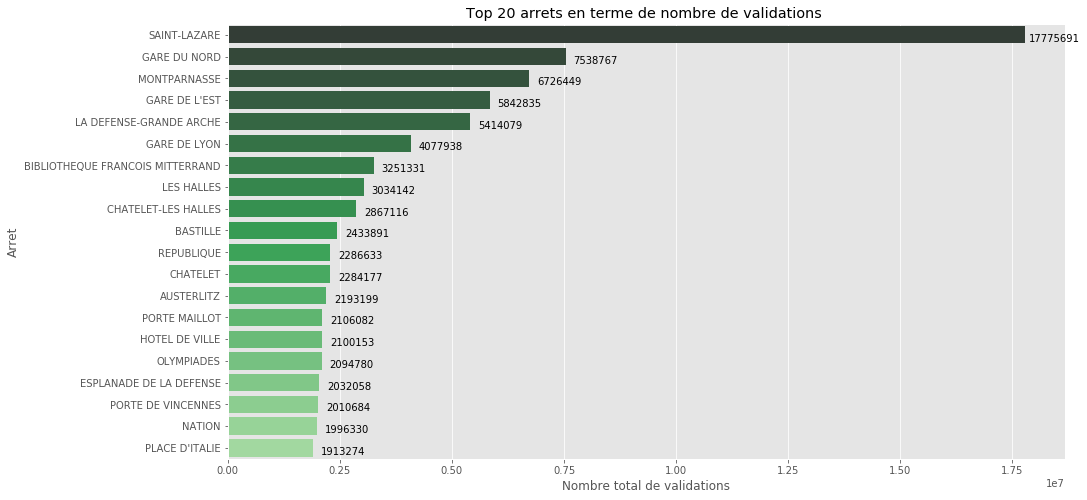

In [11]:
plt.figure(figsize=(15, 8))
pal = sns.color_palette("Greens_d", len(validations_top20))
rank = validations_top20.argsort()
g = sns.barplot(validations_top20.values, validations_top20.index, 
            palette=np.array(pal[::-1])[rank],  
            capsize=0.05,             
            saturation=8,             
            errcolor='gray', 
            errwidth=2
            )
g.set(title='Top 20 arrets en terme de nombre de validations ', 
      xlabel='Nombre total de validations', 
      ylabel='Arret'
     )
for p in g.patches:
        g.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width(), p.get_y()+p.get_height()), 
                   ha='center', va='center', xytext=(30, 5), 
                   textcoords='offset points'
                  )

## regroupement des arrêts basé sur le nombre de validations par catégories de titre

In [13]:
# convert "titre" == ? to "NON DEFINI" because it has the same mean
df['CATEGORIE_TITRE'] = df['CATEGORIE_TITRE'].replace('?', "NON DEFINI")

In [14]:
arrets_par_categories = df.pivot_table(values="NB_VALD", index="LIBELLE_ARRET", columns="CATEGORIE_TITRE", aggfunc="sum", fill_value=0)

In [15]:
arrets_par_categories

CATEGORIE_TITRE,AMETHYSTE,AUTRE TITRE,FGT,IMAGINE R,NAVIGO,NAVIGO JOUR,NON DEFINI,TST
LIBELLE_ARRET,,,,,,,,
ABBESSES,6002,11298,4497,41231,134198,658,5841,4624
ABLON,2417,5,3324,16917,68285,315,2107,4882
ACHERES-GRAND-CORMIER,552,0,720,893,4050,20,661,755
ACHERES-VILLE,6526,115,14942,62911,246570,542,11341,26365
AEROPORT CHARLES DE GAULLE 1,4258,60,15554,38663,250652,1409,10976,25806
...,...,...,...,...,...,...,...,...
VOLTAIRE (LEON BLUM),43109,29491,38139,137989,636411,1024,23920,49108
VOSVES,30,0,100,412,516,5,95,125
VULAINES-SUR-SEINE-SAMOREAU,260,0,247,811,1445,45,185,360


### In order to categorize stations into different groups, consider each station as a vector with length of 8 (number of validations in each type of transport pass)

In [16]:
# need to scale number of validations because it has not the same interval
scaler = StandardScaler()
X_8d = scaler.fit_transform(arrets_par_categories)

In [17]:
# using PCA to reduce those vectors to length of 2 for plotting in a graph
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_8d)

In [18]:
print(svd.explained_variance_ratio_.sum()) # remain 91.5% information after PCA

0.9151179330853562


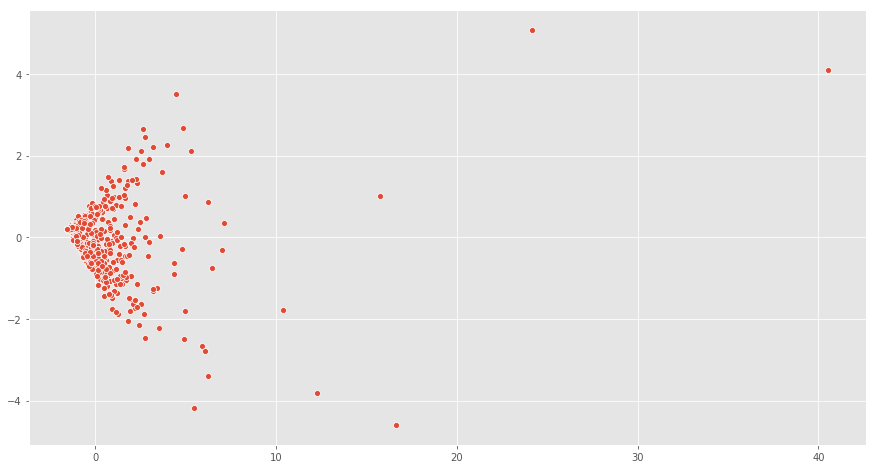

In [19]:
# try to represent those points in 2D
plt.figure(figsize=(15,8))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1])

In [20]:
# Using KMean to cluster those points. Using Within-Cluster-Sum-of-Squares (WCSS) criterion to choose the best
# number of groups
wcss = []
for num_clusters in range(1, 21):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_8d)
    wcss.append(kmeans.inertia_)

[]

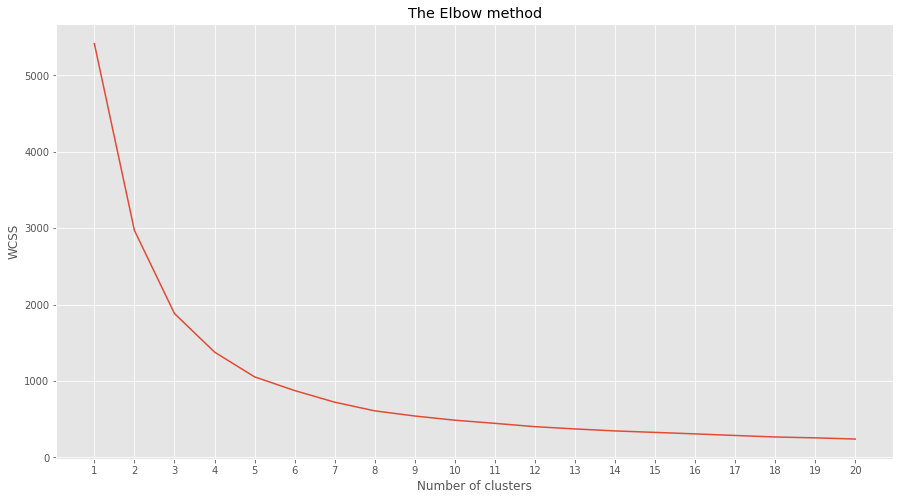

In [21]:
plt.figure(figsize=(15,8))
plt.plot(range(1, 21), wcss)
plt.xticks(range(1, 21))
plt.title("The Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.plot()

In [22]:
# Choose 4 clusters because it is considered as Elbow point
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_8d)
Y_pred = kmeans.labels_

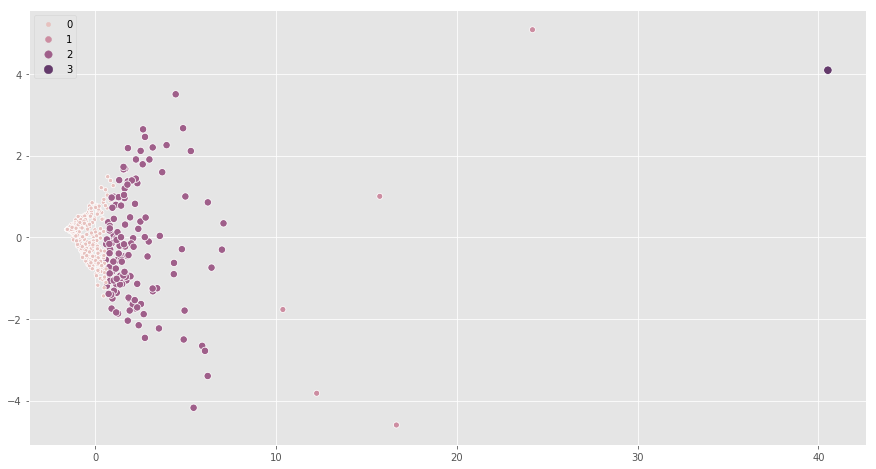

In [23]:
# plot those stations with corresponding groups
plt.figure(figsize=(15,8))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=Y_pred, size=Y_pred, palette=cmap, legend="full")

In [24]:
pd.DataFrame({"stations": arrets_par_categories.index, "groupes": Y_pred})

,stations,groupes
0,ABBESSES,0
1,ABLON,0
2,ACHERES-GRAND-CORMIER,0
3,ACHERES-VILLE,0
4,AEROPORT CHARLES DE GAULLE 1,0
...,...,...
672,VOLTAIRE (LEON BLUM),2
673,VOSVES,0
674,VULAINES-SUR-SEINE-SAMOREAU,0
675,WAGRAM,0


## Quelles prédictions pouvez vous faire pour le nombre de validations dans les stations "OLYMPIADES" et "M. MONTROUGE" sur la plage du 24 au 30 juin

In [25]:
olympiades = df.loc[df["LIBELLE_ARRET"] == "OLYMPIADES"]
olympiades = olympiades.reset_index()

In [26]:
# convert to DatetimeIndex
olympiades["JOUR"] = pd.to_datetime(olympiades["JOUR"], format="%Y-%m-%d")

In [27]:
# get number of validations per day
olympiades_nb_valid = olympiades.groupby("JOUR")["NB_VALD"].sum()

In [28]:
olympiades_nb_valid

JOUR
2020-01-01     3698
2020-01-02    21755
2020-01-03    24230
2020-01-04    17657
2020-01-05    10899
              ...  
2020-06-26    12128
2020-06-27     8613
2020-06-28     1662
2020-06-29    11386
2020-06-30    12452
Name: NB_VALD, Length: 182, dtype: int64

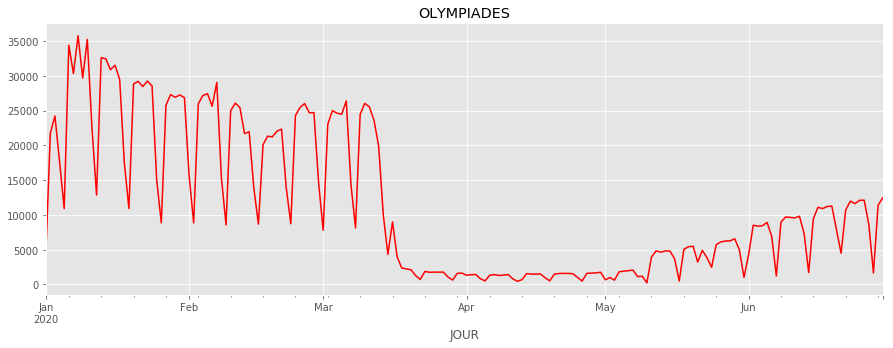

In [29]:
# plot this time serie anf try to understand the evolution
olympiades_nb_valid.plot(figsize=(15,5), color="red", title='OLYMPIADES')

In [30]:
# analysing the data in January
olympiades_janvier = olympiades_nb_valid.loc[olympiades_nb_valid.index.month == 1]

In [31]:
olympiades_janvier.values

array([ 3698, 21755, 24230, 17657, 10899, 34417, 30340, 35780, 29706,
       35250, 22572, 12868, 32618, 32472, 30894, 31533, 29481, 17512,
       10924, 28858, 29216, 28483, 29262, 28558, 15053,  8855, 25756,
       27318, 26925, 27264, 26873])

<function matplotlib.pyplot.plot(*args, **kwargs)>

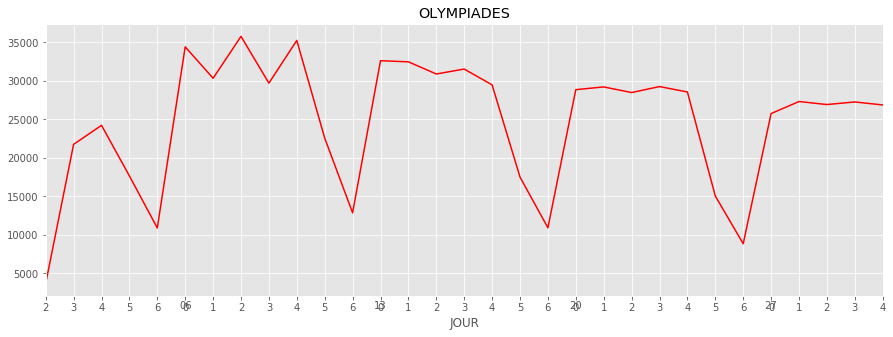

In [32]:
olympiades_janvier.plot(figsize=(15,5), color="red", title='OLYMPIADES')
plt.xticks(olympiades_janvier.index, olympiades_janvier.index.dayofweek)
plt.plot

### Obviously, the seasonal pattern has been seen in the number of validation when there is a chute on weekend before the lockdown

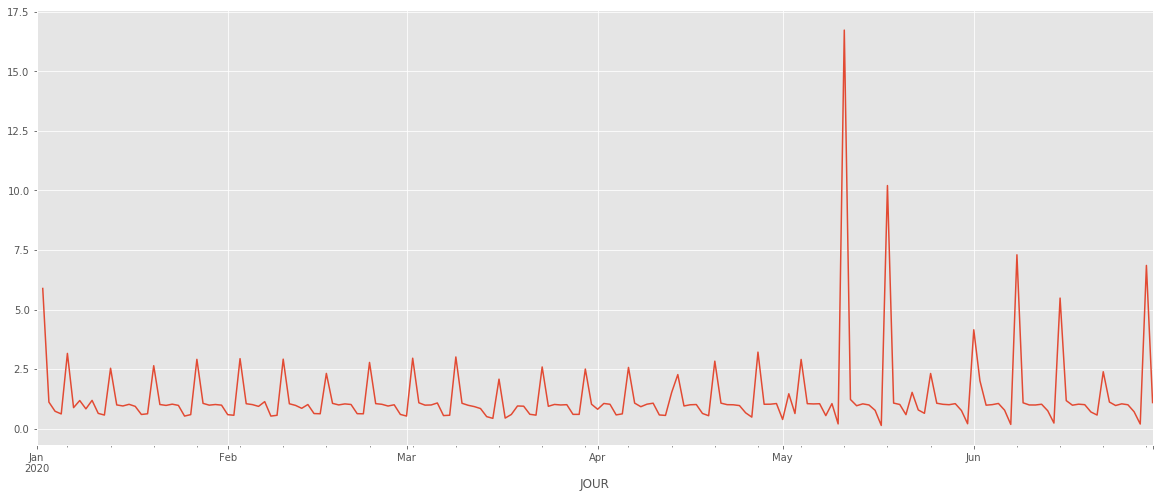

In [33]:
olympiades_nb_valid.div(olympiades_nb_valid.shift()).plot(figsize=(20,8))

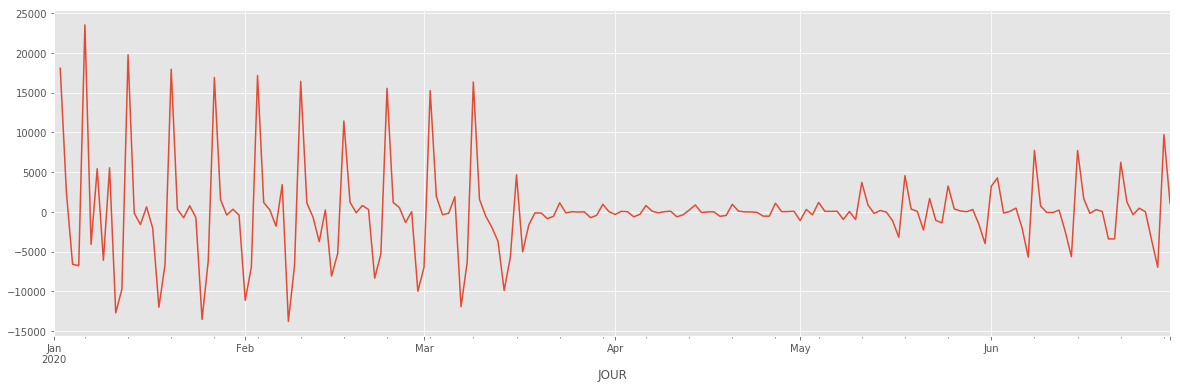

In [34]:
olympiades_nb_valid.diff().plot(figsize=(20,6))

### If we take the difference between the nb of validation on two consecutive days, the lag difference has been seen on weekend before mid March (before the lockdown) and after mid May (after the lockdown) with less rough fluctuation

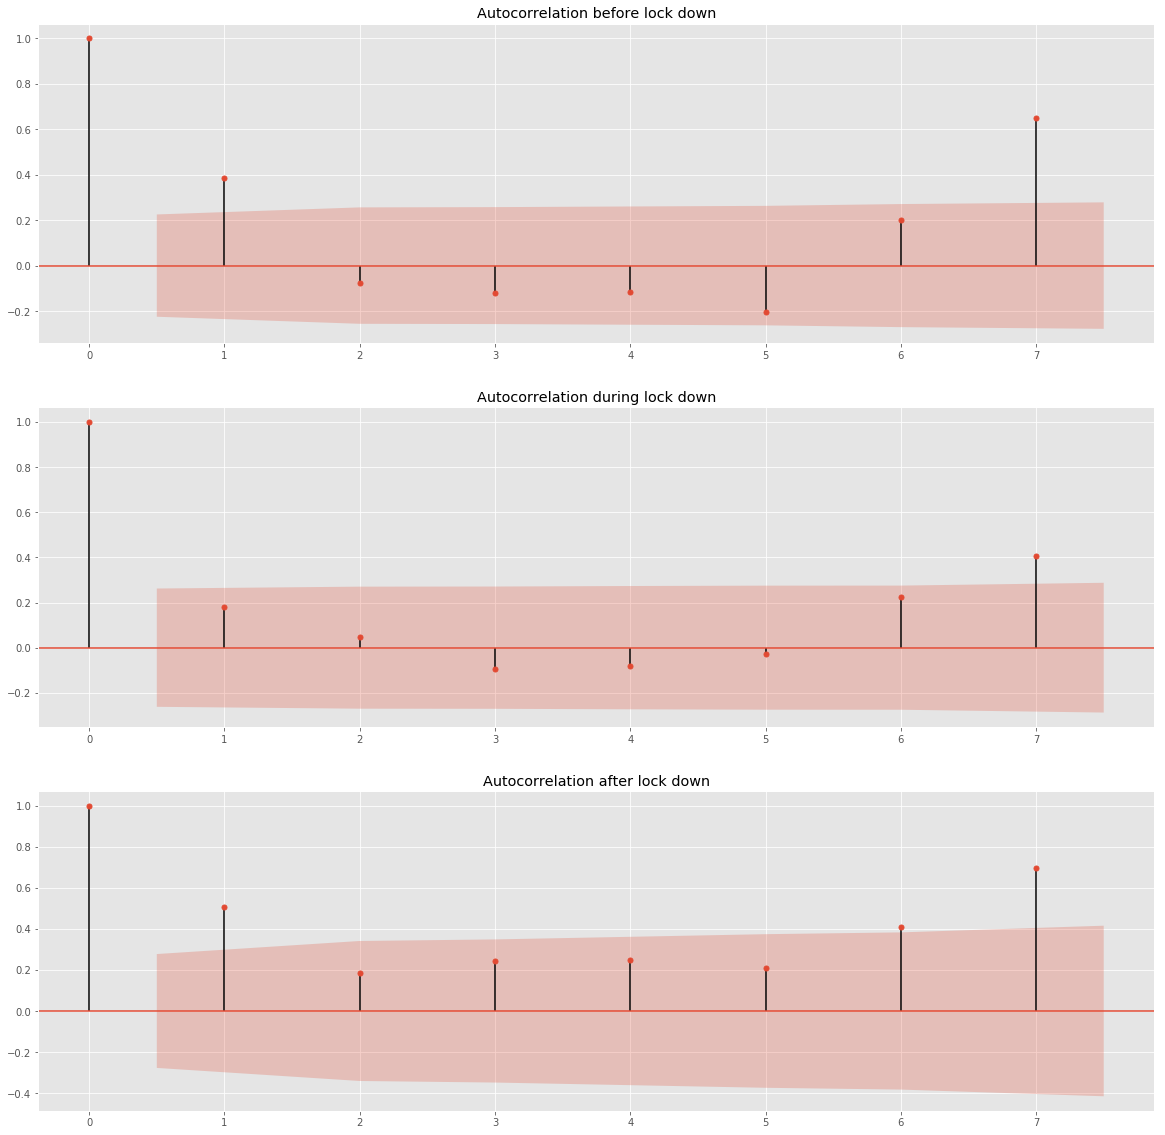

In [35]:
fix, axes = plt.subplots(3, 1, figsize=(20,20))

plot_acf(olympiades_nb_valid.loc[olympiades_nb_valid.index < "2020-03-17"],ax=axes[0], 
         lags=7,title="Autocorrelation before lock down")
plot_acf(olympiades_nb_valid.loc[(olympiades_nb_valid.index >= "2020-03-17") & (olympiades_nb_valid.index <= "2020-05-11")],ax=axes[1], 
         lags=7,title="Autocorrelation during lock down")
plot_acf(olympiades_nb_valid.loc[olympiades_nb_valid.index > "2020-05-11"],ax=axes[2], 
         lags=7,title="Autocorrelation after lock down")
plt.show()

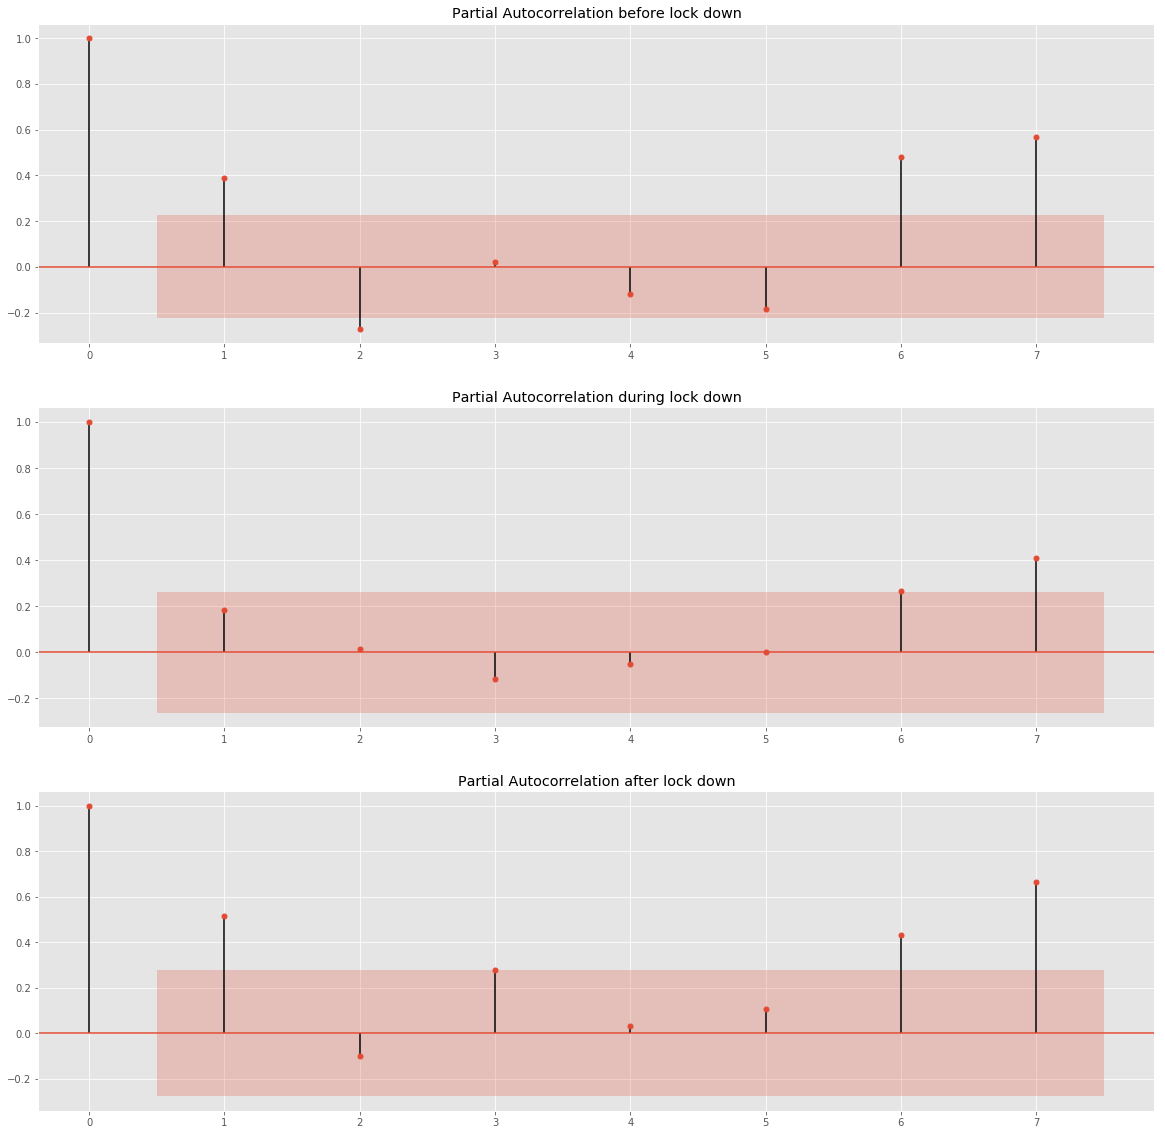

In [36]:
fix, axes = plt.subplots(3, 1, figsize=(20,20))

plot_pacf(olympiades_nb_valid.loc[olympiades_nb_valid.index < "2020-03-17"],ax=axes[0], 
         lags=7,title="Partial Autocorrelation before lock down")
plot_pacf(olympiades_nb_valid.loc[(olympiades_nb_valid.index >= "2020-03-17") & (olympiades_nb_valid.index <= "2020-05-11")],ax=axes[1], 
         lags=7,title="Partial Autocorrelation during lock down")
plot_pacf(olympiades_nb_valid.loc[olympiades_nb_valid.index > "2020-05-11"],ax=axes[2], 
         lags=7,title="Partial Autocorrelation after lock down")
plt.show()

### As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.

/home/hoangthang1607/.conda/envs/THANGHOANG/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


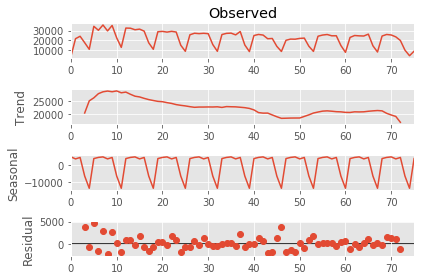

In [37]:
decomposed_olympiades = sm.tsa.seasonal_decompose(olympiades_nb_valid.loc[olympiades_nb_valid.index < "2020-03-17"].values,freq=7)
figure = decomposed_olympiades.plot()
plt.show()

### As can be seen on the decomposition of this time serie, it appears a seasonal with decreasing tendance and tend to re-bounce

### After analysing, we decide to keep only the data after the lockdown to predict (because all the data before seems to be unusual)

In [51]:
olympiades_train = olympiades_nb_valid.loc[(olympiades_nb_valid.index < "2020-06-24") & (olympiades_nb_valid.index >= "2020-05-11")].copy()
olympiades_test = olympiades_nb_valid.loc[olympiades_nb_valid.index >= "2020-06-24"].copy()

In [52]:
olympiades_train.values

array([ 3948,  4831,  4644,  4831,  4803,  3690,   496,  5061,  5428,
        5503,  3228,  4915,  3855,  2480,  5740,  6120,  6246,  6273,
        6578,  5002,  1023,  4245,  8523,  8390,  8451,  8932,  6918,
        1228,  8961,  9715,  9656,  9582,  9816,  7356,  1723,  9442,
       11104, 10923, 11216, 11278,  7885,  4494, 10732, 11985])

In [53]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    date = df.index
    X = {
        "hour": date.hour,
        "dayofweek": date.dayofweek,
        "quarter": date.quarter,
        "month": date.month,
        "year": date.year,
        "dayofyear": date.dayofyear,
        "weekofyear": date.weekofyear,
    }
    
    X = pd.DataFrame(X)
    Y = df.values

    return X, Y

In [54]:
X_train, y_train = create_features(olympiades_train)
X_test, y_test = create_features(olympiades_test)

/home/hoangthang1607/.conda/envs/THANGHOANG/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]


In [55]:
# using XGBoost Regression
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [44]:
reg.score(X_train, y_train)

0.9979530794809018

In [45]:
reg.score(X_test, y_test)

0.8702823531540856

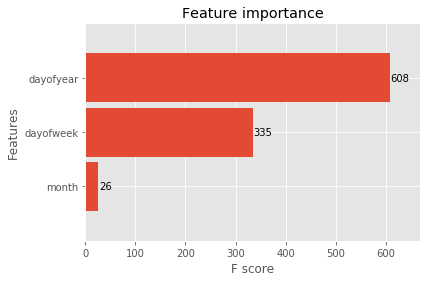

In [46]:
_ = plot_importance(reg, height=0.9)

### Top 3 of the most important features in explaining the number of validations are dayofyear, dayofweek and month, respectively

In [47]:
mean_absolute_error(y_true=y_train,
                   y_pred=reg.predict(X_train)) 

92.95842604203658

In [48]:
mean_absolute_error(y_true=y_test,
                   y_pred=reg.predict(X_test)) 

904.9465680803571

In [49]:
olympiades_test_pred = pd.Series(reg.predict(X_test), index=olympiades_test.index)

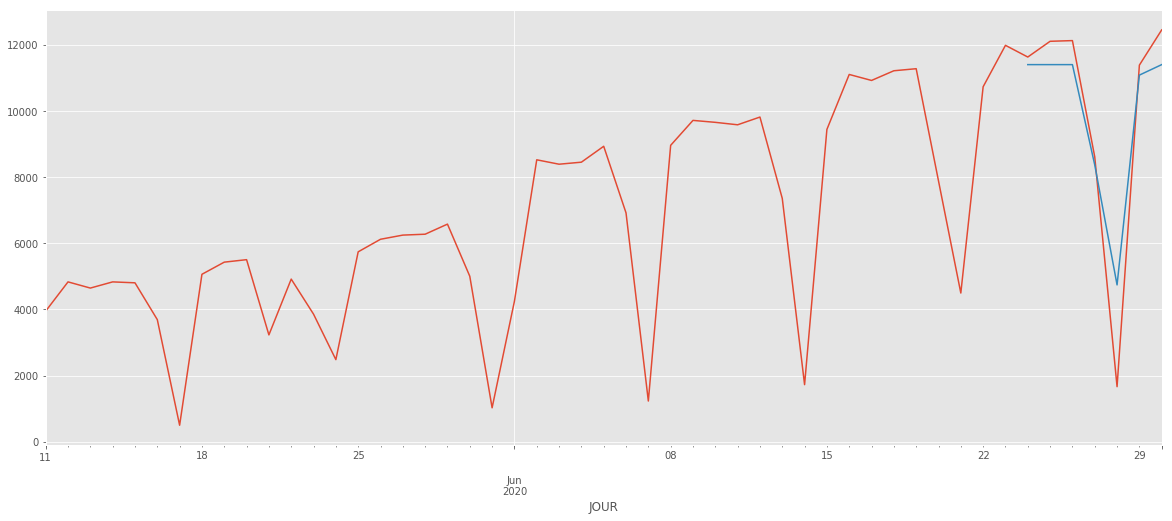

In [50]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
pd.concat([olympiades_train, olympiades_test]).plot(ax=ax)
olympiades_test_pred.plot(ax=ax)